# Bayesian Parameter Estimation and Complete Analysis

In [462]:
import sys
import numpy as np
import pandas as pd
import pystan
import altair as alt
sys.path.insert(0, '../../')
import mut.bayes
import mut.stats
import mut.thermo
import mut.viz
alt.themes.register('pboc', mut.viz.altair_config)
alt.data_transformers.enable('json')
alt.themes.enable('pboc')

ThemeRegistry.enable('pboc')

This notebook serves as a guide for the complete analysis of all collected data so far. Unless otherwise specified, parameters are taken as delta functions at their reported literature values. 

---

##  Loading and cleaning of data
Below, we load the total compiled data and split it into the three classes. We also trim the data to fitwithin realistic bounds accounting for some degree of homoscedastic error (i.e. fold-change between -0.2 and 1.2, assuming that measurement noise may bring us out of the physically restricted range of $\in [0, 1]$.

In [232]:
# Load the data and restrict to physically reasonable bounds
full_data = pd.read_csv('../../data/csv/compiled_data.csv')
data = full_data[(full_data['fold_change'] >= -0.2) & 
                 (full_data['fold_change'] <= 1.2) & 
                 (full_data['operator']=='O2')]

# Split the data into the appropriate classes
DNA_data = data[data['class']=='DNA'].copy()
IND_data = data[data['class']=='IND'].copy()
DBL_data = data[data['class']=='DBL'].copy()
WT_data = data[data['class']=='WT'].copy()

# Compute the mean and standard deviations for each for simple plotting
summarized_data = pd.DataFrame(data.groupby(['mutant', 'class', 'IPTGuM', 
                                  'repressors']).apply(mut.stats.compute_mean_sem)).reset_index()
DNA_summ = summarized_data[summarized_data['class']=='DNA'].copy()
IND_summ = summarized_data[summarized_data['class']=='IND'].copy()
DBL_summ = summarized_data[summarized_data['class']=='DBL'].copy()
WT_summ = summarized_data[summarized_data['class']=='WT'].copy()

# Assign the experimental constants. 
constants = {'ep_AI':4.5, 'O2':-13.9, 'Nns':4.6E6, 'n_sites':2, 'ka':139, 'ki':0.53, 'RBS1027':260}

# Part I: Naïve Model for DNA Binding Mutations - No Epistasis

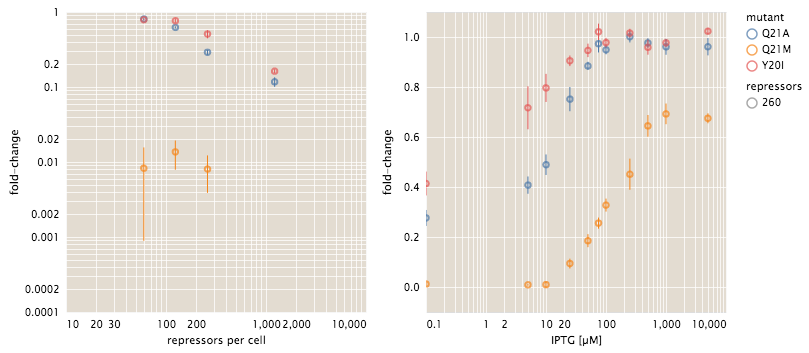

In [233]:
# Set up the two base plots
leak_base = alt.Chart(DNA_summ[(DNA_summ['IPTGuM']==0) & 
                               (DNA_summ['mean'] > 0)], width=300, height=300)
ind_base = alt.Chart(DNA_summ[(DNA_summ['IPTGuM'] > 0) & (DNA_summ['repressors'] == constants['RBS1027'])], width=300, height=300)

# Plot the leakiness data first. 
leak_points = leak_base.mark_point().encode(
                x=alt.X('repressors:Q', scale=alt.Scale(type='log'), axis={'title':'repressors per cell'}),
                y=alt.Y('mean:Q', scale=alt.Scale(type='log'), axis={'title':'fold-change'}),
                color='mutant:N').interactive()

leak_err = leak_base.mark_rule().encode(
                x=alt.X('repressors:Q', scale=alt.Scale(type='log'), axis=alt.Axis(title='repressors per cell')),
                y='ymin:Q', y2='ymax:Q',
                color='mutant:N'
            ).transform_calculate(
                ymin='datum.mean - datum.sem',
                ymax='datum.mean + datum.sem'
            )

ind_points = ind_base.mark_point().encode(
                x=alt.X('IPTGuM:Q', scale=alt.Scale(type='log'), axis={'title':'IPTG [µM]'}),
                y=alt.Y('mean:Q', axis={'title':'fold-change'}),
                color='mutant:N',
                shape='repressors:N').interactive()

ind_err = ind_base.mark_rule().encode(
                x=alt.X('IPTGuM:Q', scale=alt.Scale(type='log')),
                y='ymin:Q', y2='ymax:Q',
                color='mutant:N'
            ).transform_calculate(
                ymin='datum.mean - datum.sem',
                ymax='datum.mean + datum.sem')

(leak_points + leak_err) | (ind_points + ind_err)

Now that we have a sense of how the data behaves, we can move forward with performing the analysis. I've written a stan model which fits the DNA binding energy in log scale. The stan model can be seen below:

In [187]:
# Load the stan model code. 
ep_RA_model_code = mut.bayes.assemble_StanModelCode('../stan/DNA_binding_energy.stan', '../stan/functions.stan')
ep_RA_model = pystan.StanModel(model_code=ep_RA_model_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_760d7f07cbd488c340a8441b127f9d4f NOW.


In [234]:
# Add mutant identifiers to DNA data

DNA_idx = {m:i+1 for i, m in enumerate(DNA_data['mutant'].unique())}
for m, i in DNA_idx.items():
    DNA_data.loc[DNA_data['mutant']==m, 'idx'] = i
DNA_data['idx'] = DNA_data['idx'].values.astype(int)
leak_data = DNA_data[DNA_data['IPTGuM']==0]

# Assemble the data dictionary and sample
data_dict = dict(J=len(DNA_idx), N=len(leak_data), idx=leak_data['idx'],
                R=leak_data['repressors'], Nns=constants['Nns'], ep_ai=constants['ep_AI'],
                n_sites=constants['n_sites'], fc=leak_data['fold_change'])
ep_RA_samples = ep_RA_model.sampling(data_dict, iter=5000, chains=4)

RuntimeError: Initialization failed.

In [189]:
# Convert the samples to a data frame. 
ep_RA_df = mut.bayes.chains_to_dataframe(ep_RA_samples)

# Rename to the correct values
new_names = {'ep_RA.{}'.format(i):'ep_RA.{}'.format(m) for m, i in DNA_idx.items()}
ep_RA_df.rename(columns=new_names, inplace=True)
ep_RA_stats = mut.stats.compute_statistics(ep_RA_df)

**TODO: Write plotting function for MCMC samples**

With the sampling converged and a large number of effective samples, we can compute and plot the credible regions for each.  

In [190]:
# Find the most-likely values for ep_RA
ep_RA_mode = ep_RA_df.iloc[np.argmax(ep_RA_df['logp'].values)]

# Create a dataframe with the credible region and best fit values. 
rep_range = np.logspace(0, 4, 200)
c_range = np.logspace(-2, 4, 200)
leak_dfs = []
ind_dfs = []
for m, i in DNA_idx.items():
    # Compute the best-fit value for leakiness.
    best_fit = mut.thermo.SimpleRepression(rep_range, 
                                           ep_r=ep_RA_mode['ep_RA.{}'.format(m)],
                                          ep_ai=constants['ep_AI'], n_ns=constants['Nns'], 
                                          effector_conc=0, n_sites=constants['n_sites'],
                                          ka=constants['ka'], ki=constants['ki']).fold_change()
    
    # Compute the credible region for the leakiness.
    cred_region = np.zeros([2, len(rep_range)])
    for j, r in enumerate(rep_range):
        arch = mut.thermo.SimpleRepression(r, ep_r=ep_RA_df['ep_RA.{}'.format(m)], 
                                         effector_conc=0, ka=constants['ka'], ki=constants['ki'],
                                         ep_ai=constants['ep_AI'], n_sites=constants['n_sites']
                                         ).fold_change()
        cred_region[:, j] = mut.stats.compute_hpd(arch, 0.95)
    
    # Assemble the leakiness data frame
    _df = pd.DataFrame(np.array([rep_range, best_fit, cred_region[0, :], cred_region[1, :]]).T,
                       columns=['repressors', 'best_fit', 'hpd_min', 'hpd_max'])
    _df['mutant'] = m
    leak_dfs.append(_df)
    
    # Compute the induction curves
    best_fit = mut.thermo.SimpleRepression(constants['RBS1027'], 
                                           ep_r=ep_RA_mode['ep_RA.{}'.format(m)],
                                           ep_ai=constants['ep_AI'], n_ns=constants['Nns'], 
                                           effector_conc=c_range, n_sites=constants['n_sites'],
                                           ka=constants['ka'], ki=constants['ki']).fold_change()
    cred_region = np.zeros([2, len(c_range)])
    for j, c in enumerate(c_range):
        arch = mut.thermo.SimpleRepression(constants['RBS1027'], 
                                        ep_r=ep_RA_df['ep_RA.{}'.format(m)],
                                        ep_ai=constants['ep_AI'], n_ns=constants['Nns'], 
                                        effector_conc=c, n_sites=constants['n_sites'],
                                        ka=constants['ka'], ki=constants['ki']).fold_change()
        cred_region[:, j] = mut.stats.compute_hpd(arch, 0.95)
        
    # Assemble the induction DataFrame.
    _df = pd.DataFrame(np.array([c_range, best_fit, cred_region[0, :], cred_region[1, :]]).T,
                      columns=['IPTGuM', 'best_fit', 'hpd_min', 'hpd_max'])
    _df['mutant'] = m
    ind_dfs.append(_df)
    
# Concatenate the two data frames
leak_fit_df = pd.concat(leak_dfs)
ind_fit_df = pd.concat(ind_dfs)

In [207]:
# generate the figures. 
leak_fit_base= alt.Chart(leak_fit_df, width=300).interactive()
ind_fit_base = alt.Chart(ind_fit_df, width=300).interactive()

# modes
leak_fit_mode = leak_fit_base.mark_line().encode(
                x=alt.X('repressors:Q', scale={'type':'log'}, axis={'title':'repressors per cell'}),
                y=alt.Y('best_fit:Q', scale={'type':'log'}, axis={'title':'fold-change'}),
                color='mutant:N')
ind_fit_mode = ind_fit_base.mark_line().encode(
                x=alt.X('IPTGuM:Q', scale={'type':'log'}, axis={'title':'IPTG [µM]'}),
                y=alt.Y('best_fit:Q', axis={'title':'fold-change'}),
                color='mutant:N')
    
# Credible regions
leak_fit_cred = leak_fit_base.mark_area(opacity=0.3).encode(
                x='repressors:Q', 
                y='hpd_min:Q',
                y2='hpd_max:Q', 
                color='mutant:N',
                ) 

ind_fit_cred = ind_fit_base.mark_area(opacity=0.3).encode(
                x='IPTGuM:Q', 
                y='hpd_min:Q',
                y2='hpd_max:Q', 
                color='mutant:N',
                ) 

leak_pl
(leak_fit_mode + leak_points + leak_err + leak_fit_cred) | (ind_fit_mode )# + ind_points + ind_err)
# ind_points + ind_err + ind_fit_mode + ind_fit_cred

<VegaLite 2 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/troubleshooting.html


## Approach 2: Fitting $\Delta\varepsilon_{RA}$ to each titration curve 

After talking with Manuel, It may be more wise to do the estimation of the binding energy using a complete induction profile rather than the leakiness alone. This is more similar to what Hernan did in his 2011 PNAS, and let's us avoid some problems of noise in the measurement of fold-change bringing us below zero. I've written a stan model `DNA_binding_energy_induction.stan` that performs the estimation of $\Delta\varepsilon_{RA}$ for each curve individually.  

In [229]:
# Load the stan model
ind_prof_model_code = mut.bayes.assemble_StanModelCode('../stan/DNA_binding_energy_induction.stan',
                                                 '../stan/functions.stan')
ind_prof_model = pystan.StanModel(model_code=ind_prof_model_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_63fa70a559ef82c062be4f6bb7d824c7 NOW.


In [251]:
# Assign proper identifiers to each trace. 
REP_idx = {r:i+1 for i, r in enumerate(DNA_data['repressors'].unique())}

counter = 0
for m, i in DNA_idx.items(): 
    for r, idx in REP_idx.items():
        DNA_data.loc[(DNA_data['repressors']==r)& 
                     (DNA_data['mutant']==m), 'prof_idx'] = idx + counter
    counter += len(REP_idx)
DNA_data['prof_idx'] = DNA_data['prof_idx'].values.astype(int)

# Assemble the data dictionary
data_dict = dict(J=len(DNA_data['prof_idx'].unique()), N=len(DNA_data), 
                idx=DNA_data['prof_idx'], R=DNA_data['repressors'],
                Nns=constants['Nns'], n_sites=constants['n_sites'],
                Ka=constants['ka'], Ki=constants['ki'], c=DNA_data['IPTGuM'],
                fc=DNA_data['fold_change'], ep_ai=constants['ep_AI'])

# Sample the posterior
prof_ind_samples = ind_prof_model.sampling(data_dict, iter=10000, chains=4,
                                          pars=['ep_RA'])

In [254]:
# Properly rename the parameters
new_names = {'ep_RA.{}'.format(i+1):'ep_RA.{}.{}'.format(DNA_data[DNA_data['prof_idx']==i+1]['mutant'].unique()[0],
                                                      int(DNA_data[DNA_data['prof_idx']==i+1]['repressors'].unique()[0])
                                                        ) for i in range(len(DNA_data['prof_idx'].unique()))}

# Format the dataframe. 
prof_ind_df = mut.bayes.chains_to_dataframe(prof_ind_samples)
prof_ind_df.rename(columns=new_names, inplace=True)

# Compute the statistics
prof_ind_stats = mut.stats.compute_statistics(prof_ind_df)

In [301]:
# Assemble a useable dataframe
for i, par in enumerate(prof_ind_stats['parameter'].unique()):
    _, m, r = par.split('.')
    
    # Include the relevant information in the dataframe. 
    prof_ind_stats.loc[prof_ind_stats['parameter']==par, 'mutant'] = m
    prof_ind_stats.loc[prof_ind_stats['parameter']==par, 'repressors'] = int(r)

# Save the statistics to disk
prof_ind_stats.to_csv('../../data/csv/DNA_binding_energy_induction_profile_estimation.csv')

In [273]:
# Plot the estimated parameter values. 
base = alt.Chart(prof_ind_stats, width=300, height=300).interactive()

points = base.mark_point().encode(
        x=alt.X('repressors:O', axis={'title':'repressors per cell'}),
        y=alt.Y('mode:Q', axis={'title':'DNA Binding Energy (kBT)'}),
        color='mutant:N')

points + hpd

<VegaLite 2 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/troubleshooting.html


In [485]:
def compute_pairwise_predictions_R(point_df, stat_df,constants):
    # Get the
    reps = stat_df['repressors'].unique()
    mutants = stat_df['mutant'].unique()
    print(mutants)
    dfs = []
    for predictor in reps:
        # Isolate the parameters
        mode = stat_df[stat_df['repressors']==predictor]['mode'].values
        hpd_min = stat_df[stat_df['repressors']==predictor]['hpd_min'].values
        hpd_max = stat_df[stat_df['repressors']==predictor]['hpd_max'].values
        epR = np.array([mode, hpd_min, hpd_max]).T
    
        
        # Mesh the parameters with the valid range of IPTG values
        c_range = np.logspace(np.floor(np.log10(point_df['IPTGuM'].values.min())) - 1,
                             np.ceil(np.log10(point_df['IPTGuM'].values.max())), 200)
        c_mesh, epR_mesh, R_mesh= np.meshgrid(c_range, epR, reps) 
        
        # Compute the fold-change.
        fc = mut.thermo.SimpleRepression(R=R_mesh, ep_r=epR_mesh, effector_conc=c_mesh,
                                         n_ns=constants['Nns'], ep_ai=constants['ep_AI'], 
                                         ka=constants['ka'], ki=constants['ki']).fold_change()
        for i, r in enumerate(reps):
            rep_fc = fc[:, :, i]
            z = 0
            for j in range(0, np.shape(fc)[0], 3):
                rep_mut_fc = rep_fc[j:j+3,:]
                _df = pd.DataFrame(rep_mut_fc.T, columns=['mode', 'hpd_min', 'hpd_max'])
                _df['IPTGuM'] = c_range
                _df['repressors'] = r
                _df['mutant'] = mutants[z] 
                _df['predictor'] = predictor
                dfs.append(_df)
                z += 1

    return pd.concat(dfs)

In [486]:
a.mutant.unique()

array(['Q21M'], dtype=object)

In [487]:
a = compute_pairwise_predictions_R(DNA_summ[DNA_summ['IPTGuM'] > 0], prof_ind_stats, constants)

['Q21M' 'Q21A' 'Y20I']


In [514]:
base = alt.Chart(a)

modes = base.mark_line().encode(
    x=alt.X('IPTGuM:Q', scale={'type':'log'}),
    y=alt.Y('mode:Q', axis={'title':'fold-change'}),
    row='predictor:Q',
    color='mutant:N')

hpds = base.mark_area(opacity=0.4).encode(
    x=alt.X('IPTGuM:Q', scale={'type':'log'}),
    y=alt.Y('hpd_min:Q', axis={'title':'fold-change'}),
    y2='hpd_max:Q',
 color='mutant:N')

modes.facet(column='repressors:O', row='predictor:O', data=a)

SchemaValidationError: Invalid specification

        altair.vegalite.v2.api.FacetChart->spec, validating 'anyOf'

        {'data': {'url': 'altair-data-4cc4049c040b9ee47e687b1d89994732.json', 'format': {'type': 'json'}}, 'mark': 'line', 'encoding': {'color': {'type': 'nominal', 'field': 'mutant'}, 'row': {'type': 'quantitative', 'field': 'predictor'}, 'x': {'type': 'quantitative', 'field': 'IPTGuM', 'scale': {'type': 'log'}}, 'y': {'type': 'quantitative', 'axis': {'title': 'fold-change'}, 'field': 'mode'}}} is not valid under any of the given schemas
        

FacetChart({
  data:          mode   hpd_min   hpd_max        IPTGuM  repressors mutant  predictor
  0    0.003304  0.003060  0.003758      0.010000         260   Q21M        260
  1    0.003304  0.003060  0.003758      0.010719         260   Q21M        260
  2    0.003304  0.003060  0.003758      0.011490         260   Q21M        260
  3    0.003304  0.003060  0.003758      0.012316         260   Q21M        260
  4    0.003304  0.003060  0.003758      0.013201         260   Q21M        260
  5    0.003305  0.003061  0.003758      0.014150         260   Q21M        260
  6    0.003305  0.003061  0.003758      0.015167         260   Q21M        260
  7    0.003305  0.003061  0.003759      0.016258         260   Q21M        260
  8    0.003305  0.003061  0.003759      0.017426         260   Q21M        260
  9    0.003305  0.003061  0.003759      0.018679         260   Q21M        260
  10   0.003305  0.003061  0.003759      0.020022         260   Q21M        260
  11   0.003306  0.00

In [511]:
modes.mark_line?

Signature: modes.mark_line(align=Undefined, angle=Undefined, baseline=Undefined, binSpacing=Undefined, clip=Undefined, color=Undefined, cursor=Undefined, dx=Undefined, dy=Undefined, fill=Undefined, fillOpacity=Undefined, filled=Undefined, font=Undefined, fontSize=Undefined, fontStyle=Undefined, fontWeight=Undefined, href=Undefined, interpolate=Undefined, limit=Undefined, line=Undefined, opacity=Undefined, orient=Undefined, point=Undefined, radius=Undefined, shape=Undefined, size=Undefined, stroke=Undefined, strokeCap=Undefined, strokeDash=Undefined, strokeDashOffset=Undefined, strokeOpacity=Undefined, strokeWidth=Undefined, style=Undefined, tension=Undefined, text=Undefined, theta=Undefined, **kwds)
Docstring:
Set the chart's mark to 'line'

For information on additional arguments, see ``alt.MarkDef``
File:      /anaconda3/lib/python3.6/site-packages/altair/vegalite/v2/schema/mixins.py
Type:      method


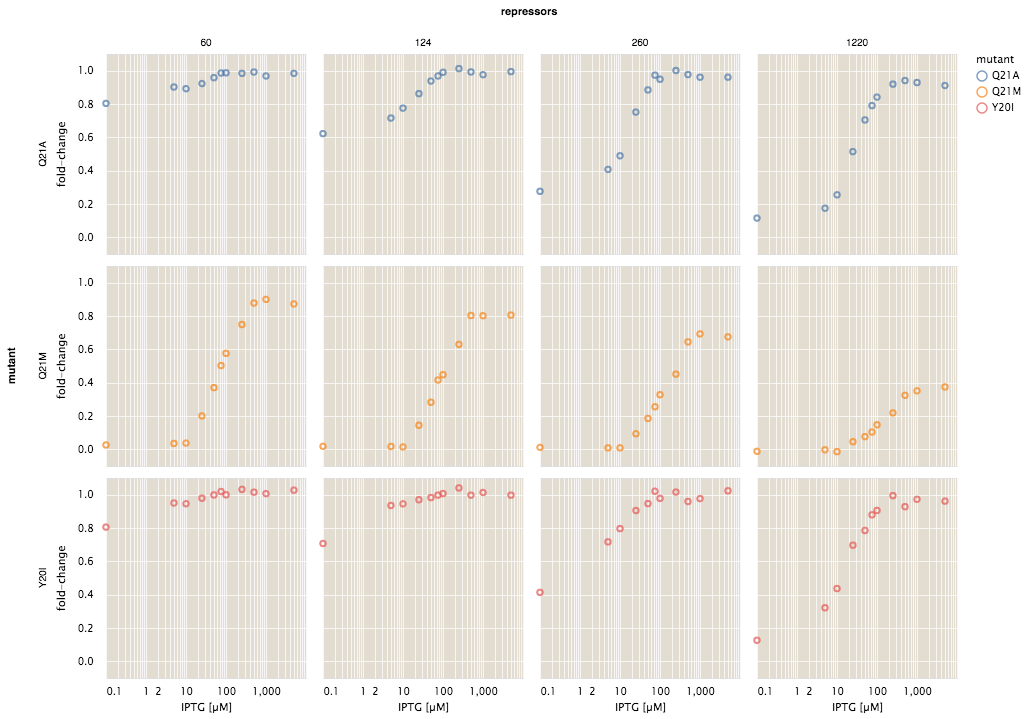

In [455]:
a = alt.Chart(DNA_summ[DNA_summ['IPTGuM'] > 0]).mark_point().encode(
    x=alt.X('IPTGuM:Q', scale={'type':'log'}, axis={'title':'IPTG [µM]'}),
    y=alt.Y('mean:Q', axis={'title':'fold-change'}),
    color='mutant:N').facet(
    column='repressors:O',
    row='mutant:O')

# b = alt.Chart(DNA_summ[DNA_summ['IPTGuM'] > 0]).mark_square().encode(
#     x=alt.X('IPTGuM:Q', scale={'type':'log'}, axis={'title':'IPTG [µM]'}),
#     y=alt.Y('mean:Q', axis={'title':'fold-change'}),
#     color='mutant:N',
#     column='repressors:O',
#     row='mutant:O')


# b = alt.Chart(DNA_summ[DNA_summ['IPTGuM'] > 0]).mark_rule().encode(
#     x=alt.X('IPTGuM:Q', scale={'type':'log'}, axis={'title':'IPTG [µM]'}),
#     y=alt.Y('ymin:Q', axis={'title':'fold-change'}),
#     y2='ymax:Q',
#     color='mutant:N',
#     column='repressors:O',
#     row='mutant:O'
#     ).transform_calculate(
#     ymin='datum.mean - datum.sem',
#     ymax='datum.mean + datum.sem')
a